In [2]:
# Load required libraries
library(tidyverse)
library(janitor)
library(dplyr)
library(ggplot2)
library(skimr)
library(purrr)
library(lubridate)

# Source helper scripts
source("../../R/apply_factors.R")
source("../../R/analysis_helpers.R")
source("../../R/temporal_helpers.R")

# Load data
tables <- list(
  Orders  = readr::read_csv("../../data/processed/Orders.csv"),
  Returns = readr::read_csv("../../data/processed/Returns.csv"),
  People  = readr::read_csv("../../data/processed/People.csv")
)

# Apply factor transformations
tables <- apply_factors(tables)

# Extract tables
orders  <- tables$Orders
returns <- tables$Returns
people  <- tables$People

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Rows: 51290 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (13): order_id, ship_mode, customer_name, segment, state, country, mark...
dbl   (6): sales, quantity, discount, profit, shipping_cost, year
date  (2): order_date, ship_date

ℹ Use `spec()` to retrieve the full column specification f

# Executive Overview (Organization-Wide)

### Total Sales, Profit, Margin (single KPI-style bars)

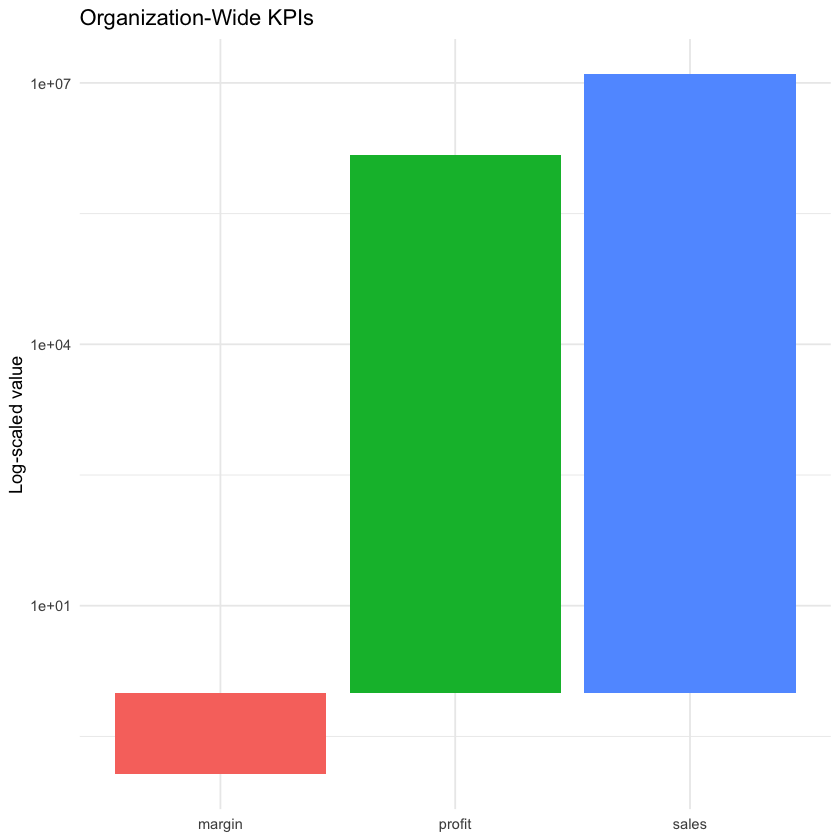

In [3]:
org_kpis <- orders |> 
    summarise(
        sales = sum(sales),
        profit = sum(profit),
        margin = sum(profit) / sum(sales)
    ) |> 
    pivot_longer(everything(), names_to = "metric", values_to = "value")

ggplot(org_kpis, aes(metric, value, fill = metric)) + 
    geom_col() + 
    scale_y_continuous(trans = "log10") + 
    labs(
        title = "Organization-Wide KPIs", 
        x = NULL, 
        y = "Log-scaled value"
    ) + 
    theme_minimal() + 
    theme(legend.position = "none")

### Orders vs Profit 

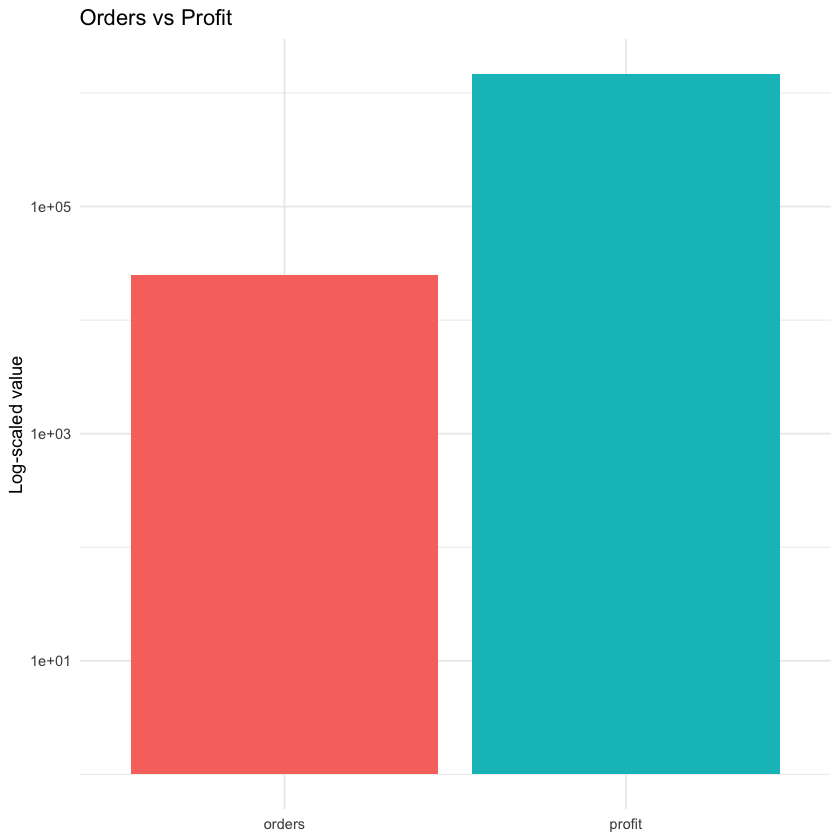

In [4]:
orders |> 
    summarise(orders = n_distinct(order_id), 
              profit = sum(profit)) |> 
    pivot_longer(everything()) |> 
    ggplot(aes(name, value, fill = name)) + 
    geom_col() + 
    scale_y_continuous(trans = "log10") + 
    labs(title = "Orders vs Profit", 
         x = NULL, 
         y = "Log-scaled value") + 
    theme_minimal() + 
    theme(legend.position = "none")

# Performance of Regional Managers

### Sales, Orders, and Profit by regional manager

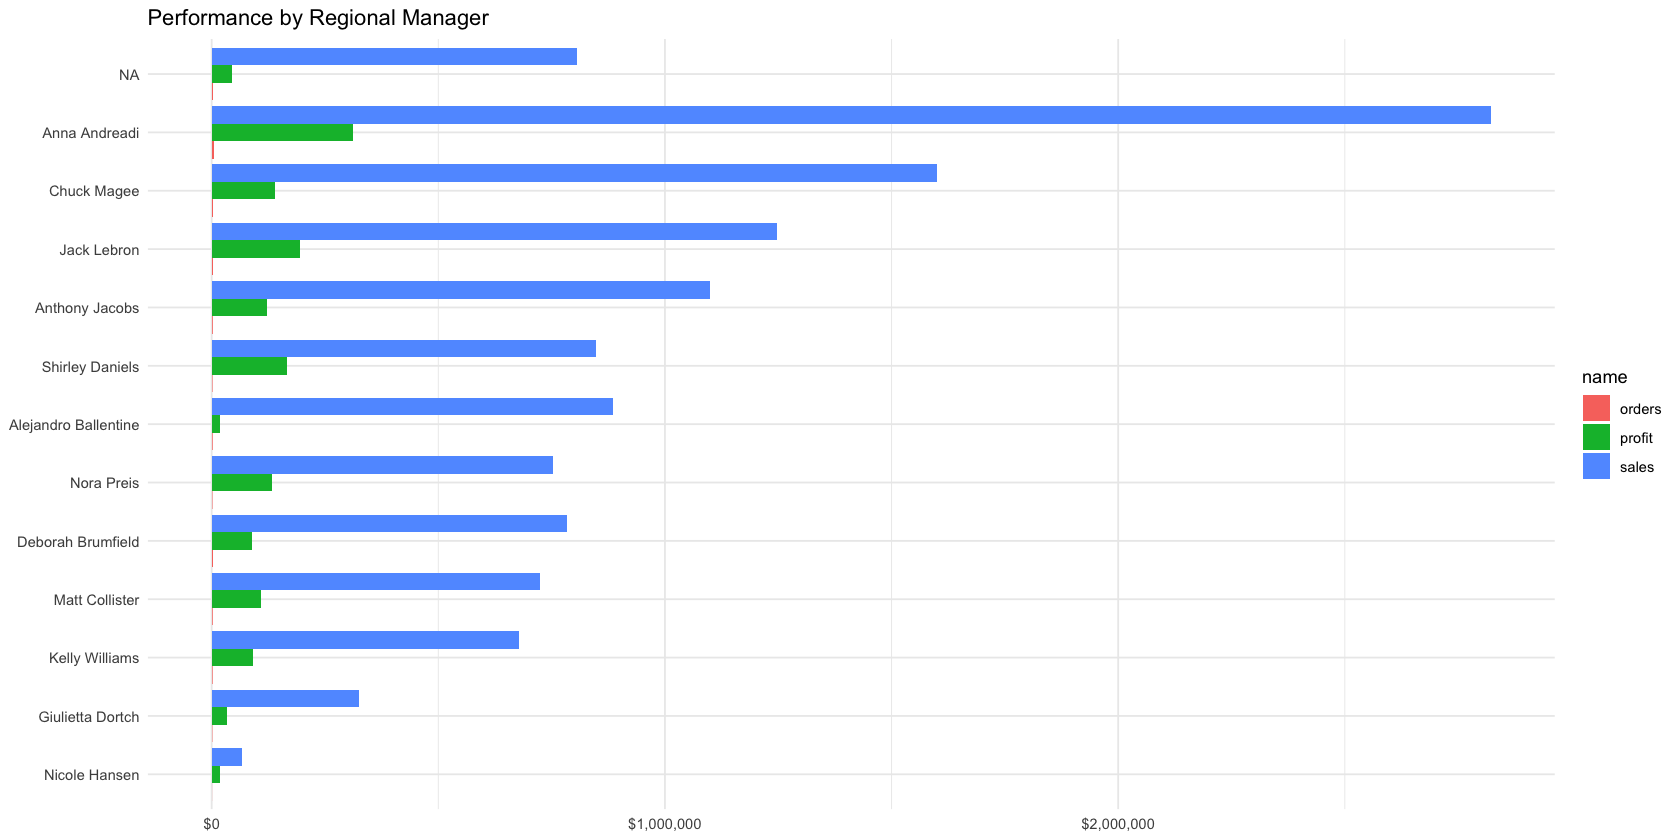

In [14]:
options(repr.plot.width = 14, repr.plot.height = 7)

orders_org <- orders |> 
    left_join(people, by = "region")

orders_org |> 
    group_by(person) |> 
    summarise(
        sales = sum(sales),
        profit = sum(profit),
        orders = n_distinct(order_id)
    ) |> 
    pivot_longer(-person) |> 
    ggplot(aes(reorder(person, value), value, fill = name)) + 
    geom_col(position = "dodge") + 
    coord_flip() + 
    scale_y_continuous(labels = scales::dollar_format()) + 
    labs(title = "Performance by Regional Manager", 
         x = NULL, 
         y = NULL) + 
    theme_minimal()

### Operational Efficiency Signals (profit margin distribution)

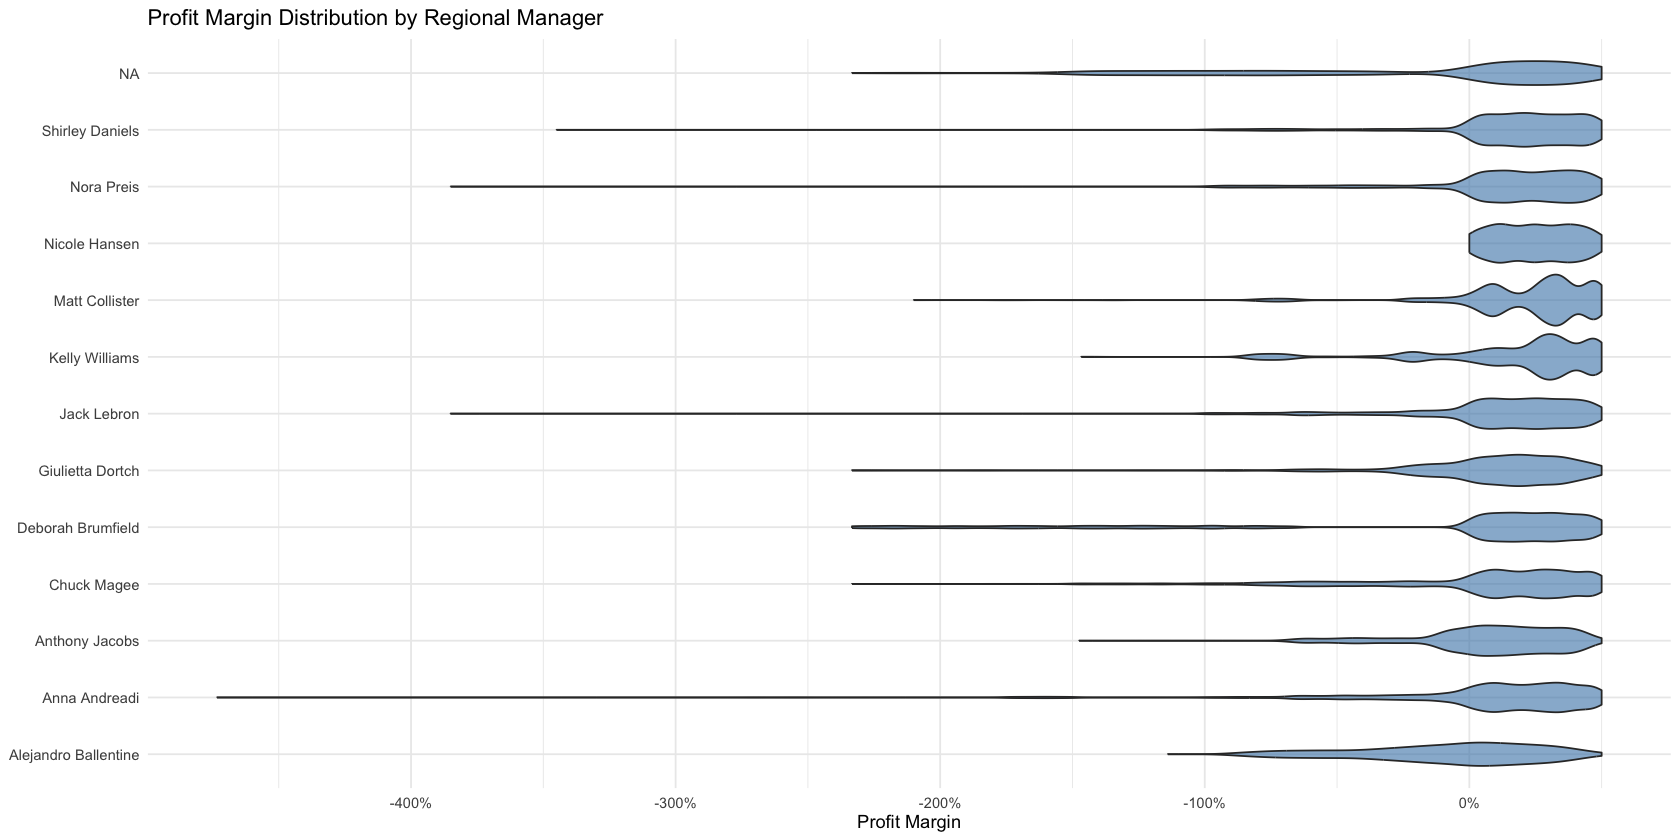

In [15]:
orders_org |> 
    mutate(margin = profit / sales) |> 
    ggplot(aes(person, margin)) + 
    geom_violin(fill = "steelblue", alpha = 0.6) + 
    coord_flip() + 
    scale_y_continuous(labels = scales::percent) + 
    labs(title = "Profit Margin Distribution by Regional Manager", 
         x = NULL, 
         y = "Profit Margin") + 
    theme_minimal()

### Discount levels by regional manager

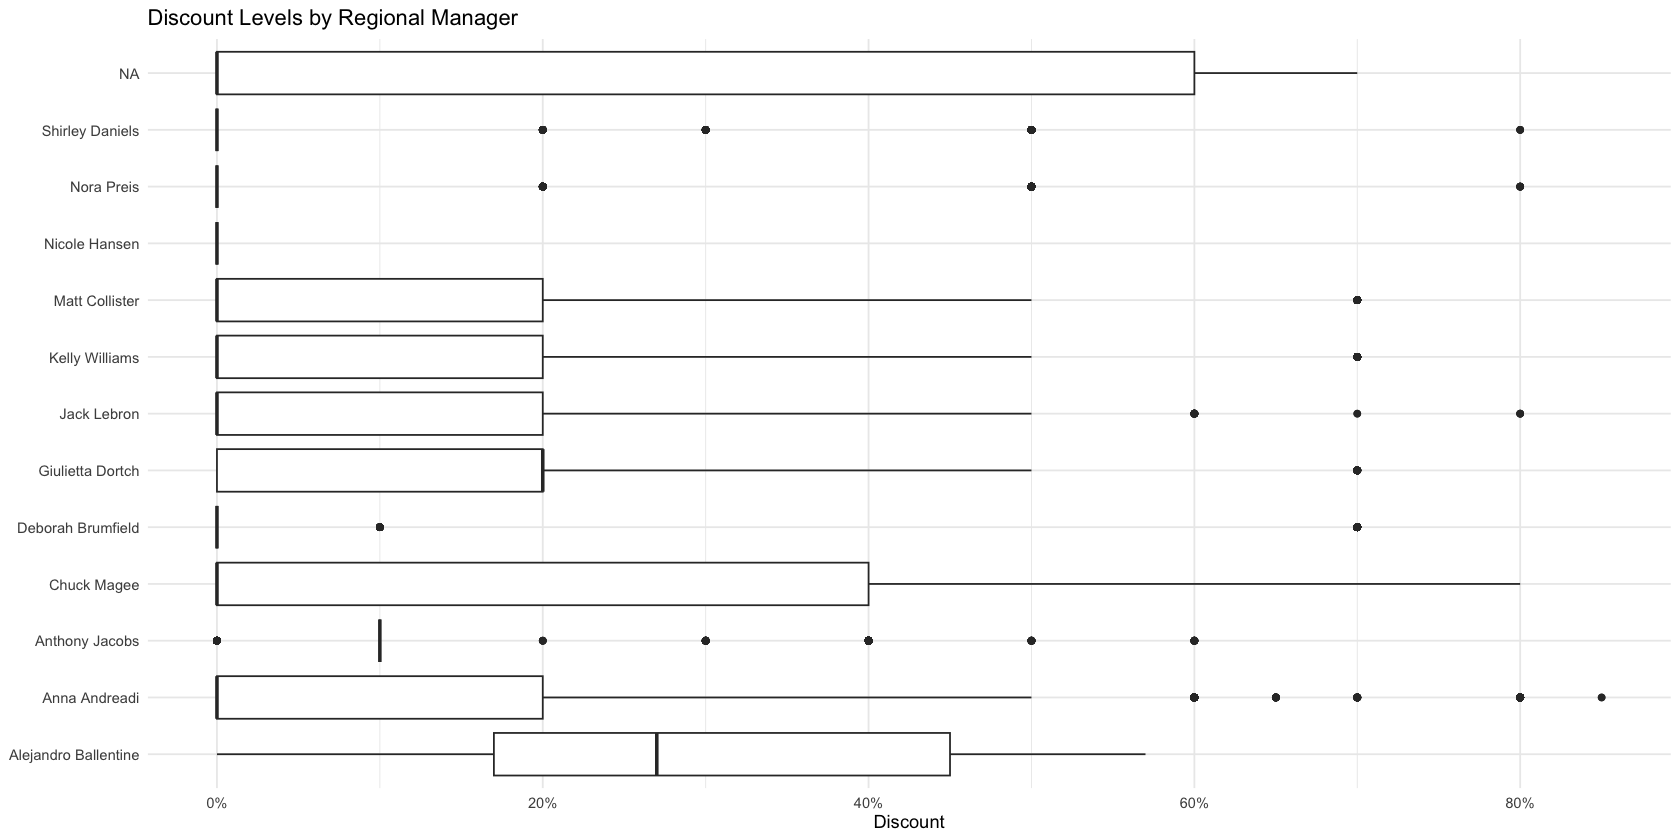

In [16]:
orders_org |> 
    ggplot(aes(person, discount)) + 
    geom_boxplot() + 
    coord_flip() + 
    scale_y_continuous(labels = scales::percent) + 
    labs(title = "Discount Levels by Regional Manager", 
         x = NULL, 
         y = "Discount") + 
    theme_minimal()

### Return rates by regional manager

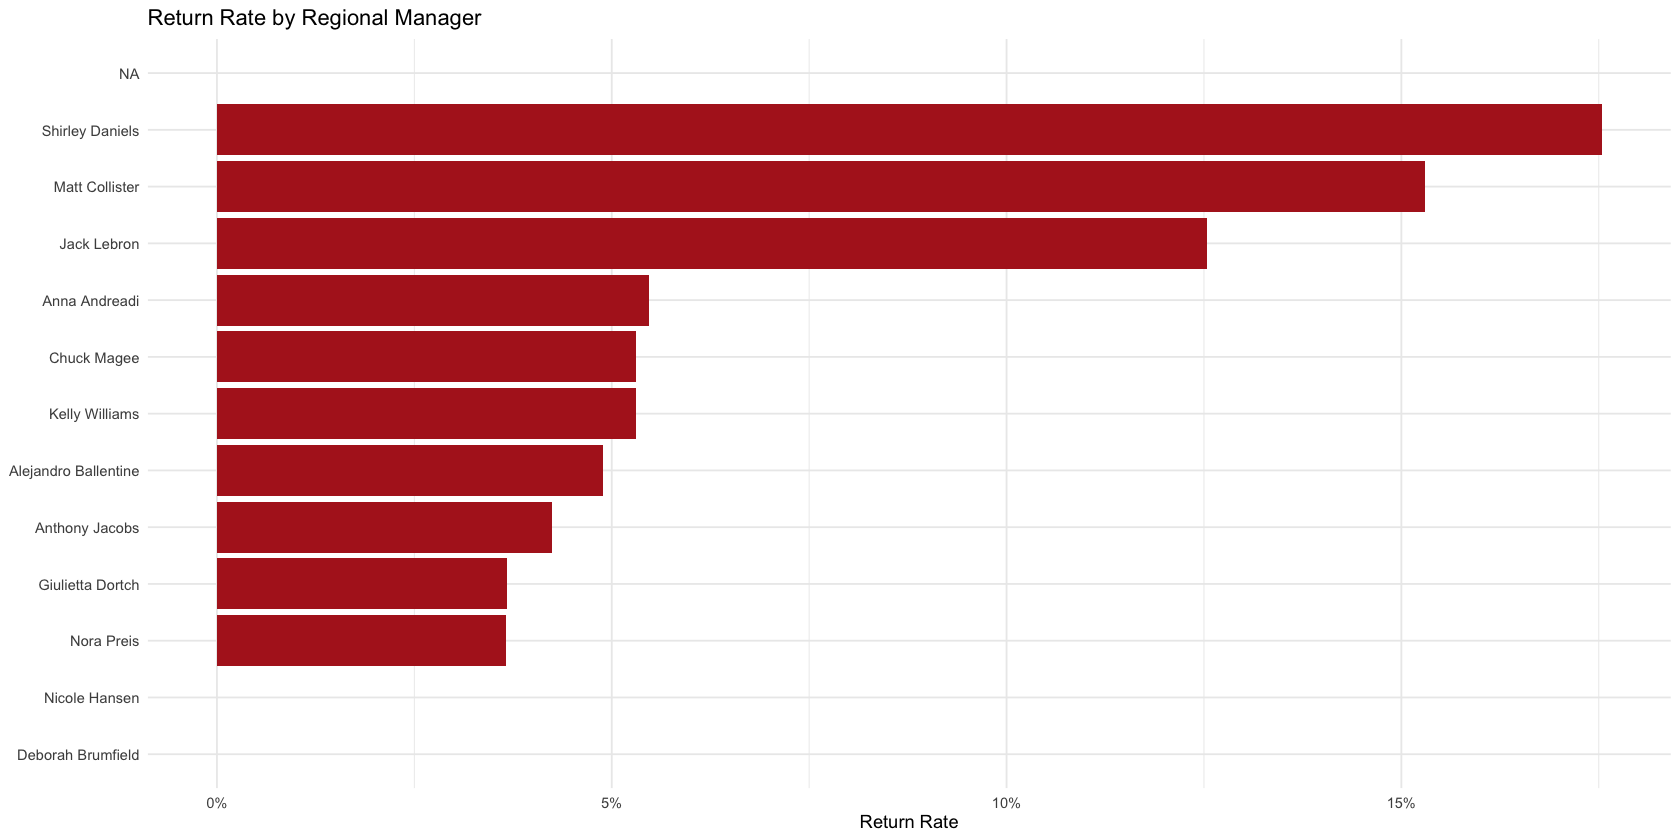

In [17]:
orders_with_returns <- orders |> 
    left_join(
        returns |> 
            distinct(order_id) |> 
            mutate(returned = 1),
        by = "order_id"
    ) |> 
    mutate(returned = if_else(is.na(returned), 0, returned))
    
orders_with_returns |> 
    left_join(people, by = "region") |> 
    group_by(person) |> 
    summarise(return_rate = mean(returned)) |> 
    ggplot(aes(reorder(person, return_rate), return_rate)) + 
    geom_col(fill = "firebrick") + 
    coord_flip() + 
    scale_y_continuous(labels = scales::percent) + 
    labs(title = "Return Rate by Regional Manager", 
         x = NULL, 
         y = "Return Rate") + 
    theme_minimal()

# Risk & Volatility

### Profit volatility by regional manager (SD)

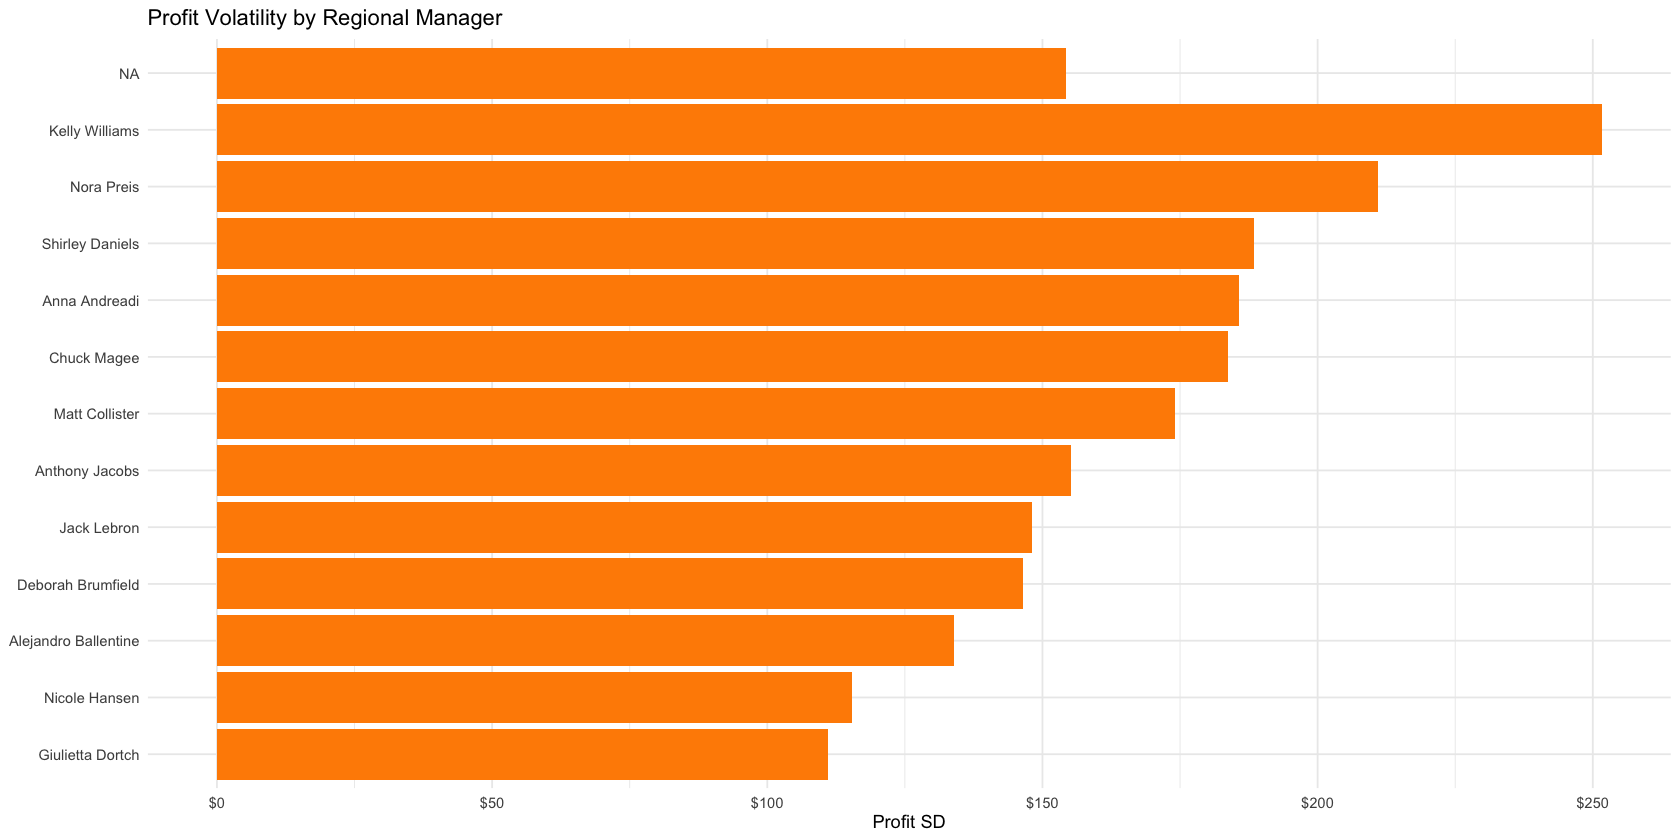

In [18]:
orders_org |> 
    group_by(person) |> 
    summarise(profit_sd = sd(profit)) |> 
    ggplot(aes(reorder(person, profit_sd), profit_sd)) + 
    geom_col(fill = "darkorange") + 
    coord_flip() + 
    scale_y_continuous(labels = scales::dollar_format()) + 
    labs(title = "Profit Volatility by Regional Manager", 
         x = NULL, 
         y = "Profit SD") + 
    theme_minimal()

### Return-rate volatility by regional manager

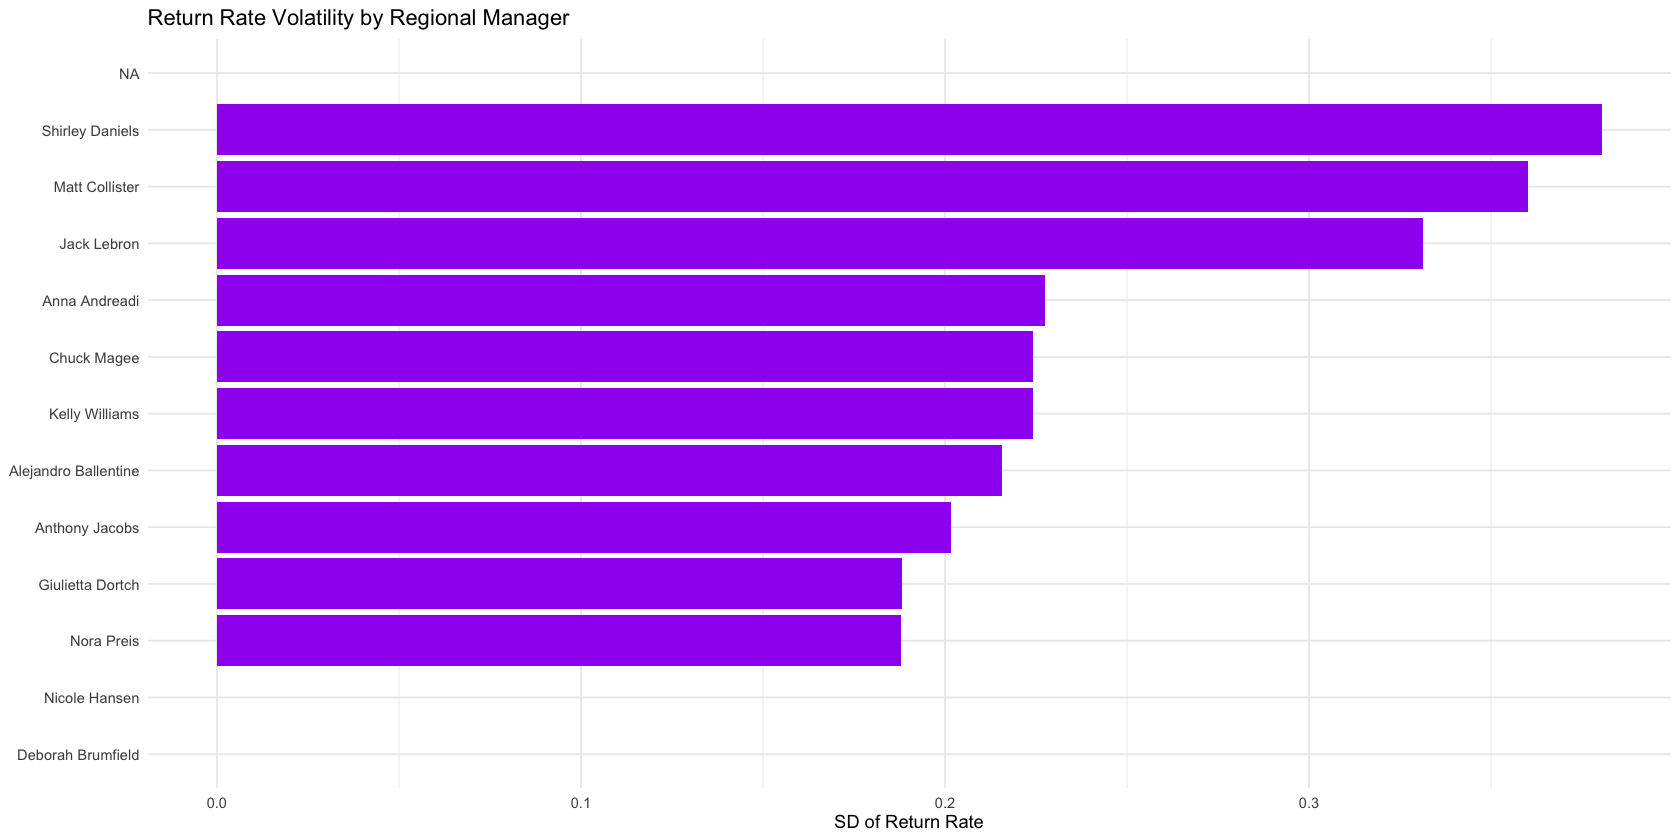

In [19]:
orders_with_returns |> 
    left_join(people, by = "region") |> 
    group_by(person) |> 
    summarise(return_sd = sd(returned)) |> 
    ggplot(aes(reorder(person, return_sd), return_sd)) + 
    geom_col(fill = "purple") + 
    coord_flip() + 
    labs(title = "Return Rate Volatility by Regional Manager", 
         x = NULL, 
         y = "SD of Return Rate") + 
    theme_minimal()

### Discount Sensititvity by regional manager

`geom_smooth()` using formula = 'y ~ x'


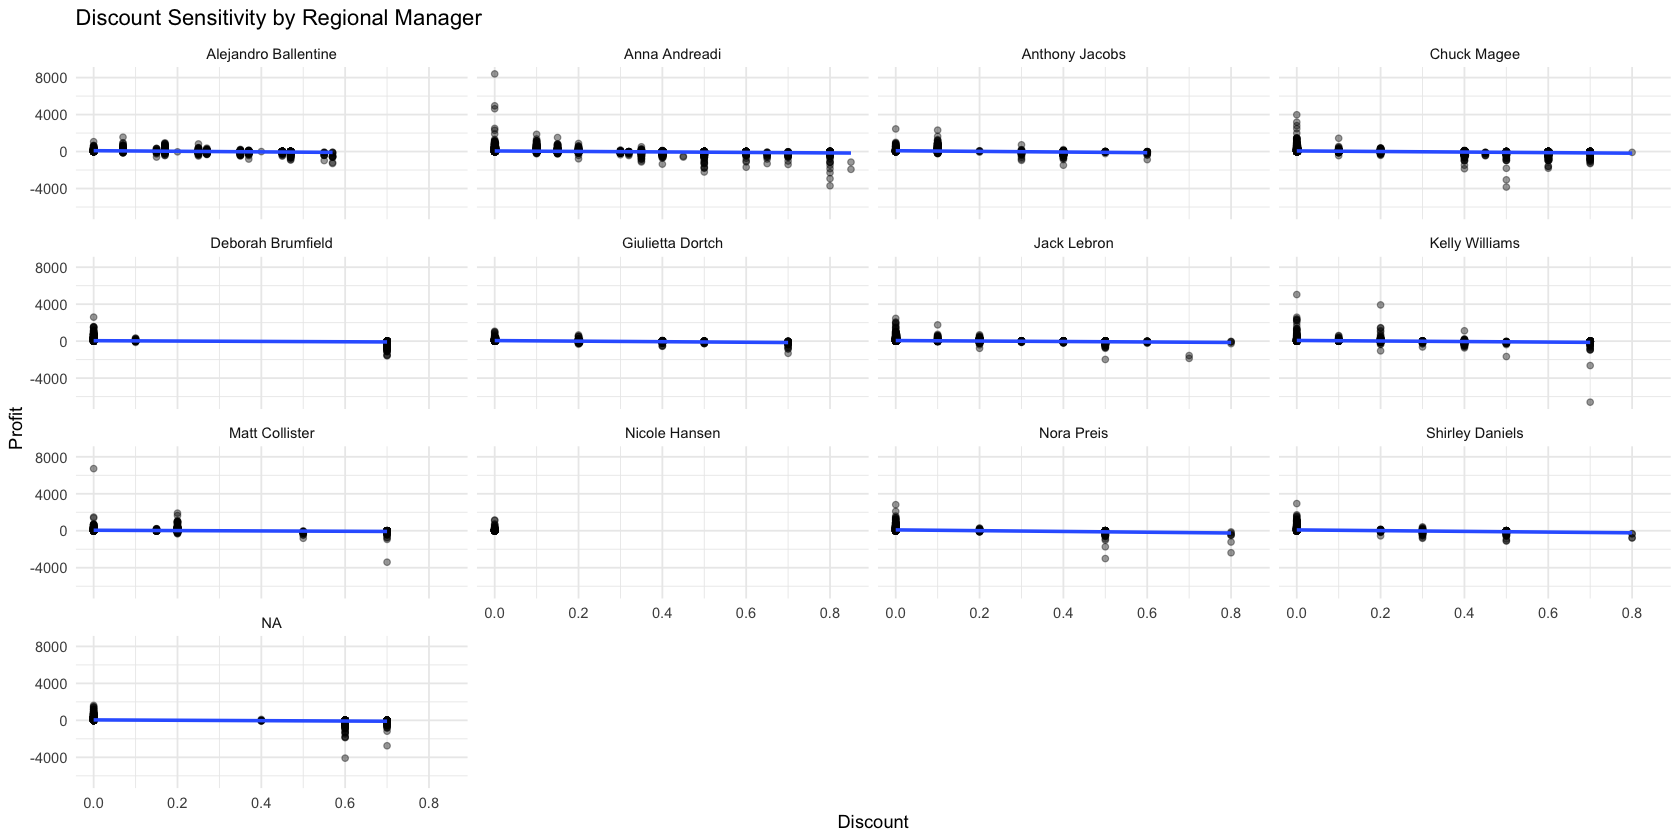

In [20]:
orders_org |> 
    ggplot(aes(discount, profit)) + 
    geom_point(alpha = 0.4) + 
    geom_smooth(method = "lm", se = FALSE) + 
    facet_wrap(~person) + 
    labs(
        title = "Discount Sensitivity by Regional Manager", 
        x = "Discount", 
        y = "Profit"
    ) + 
    theme_minimal()

# Concentration & Dependency

### Top X% of regional managers vs total profit contribution (pareto style)

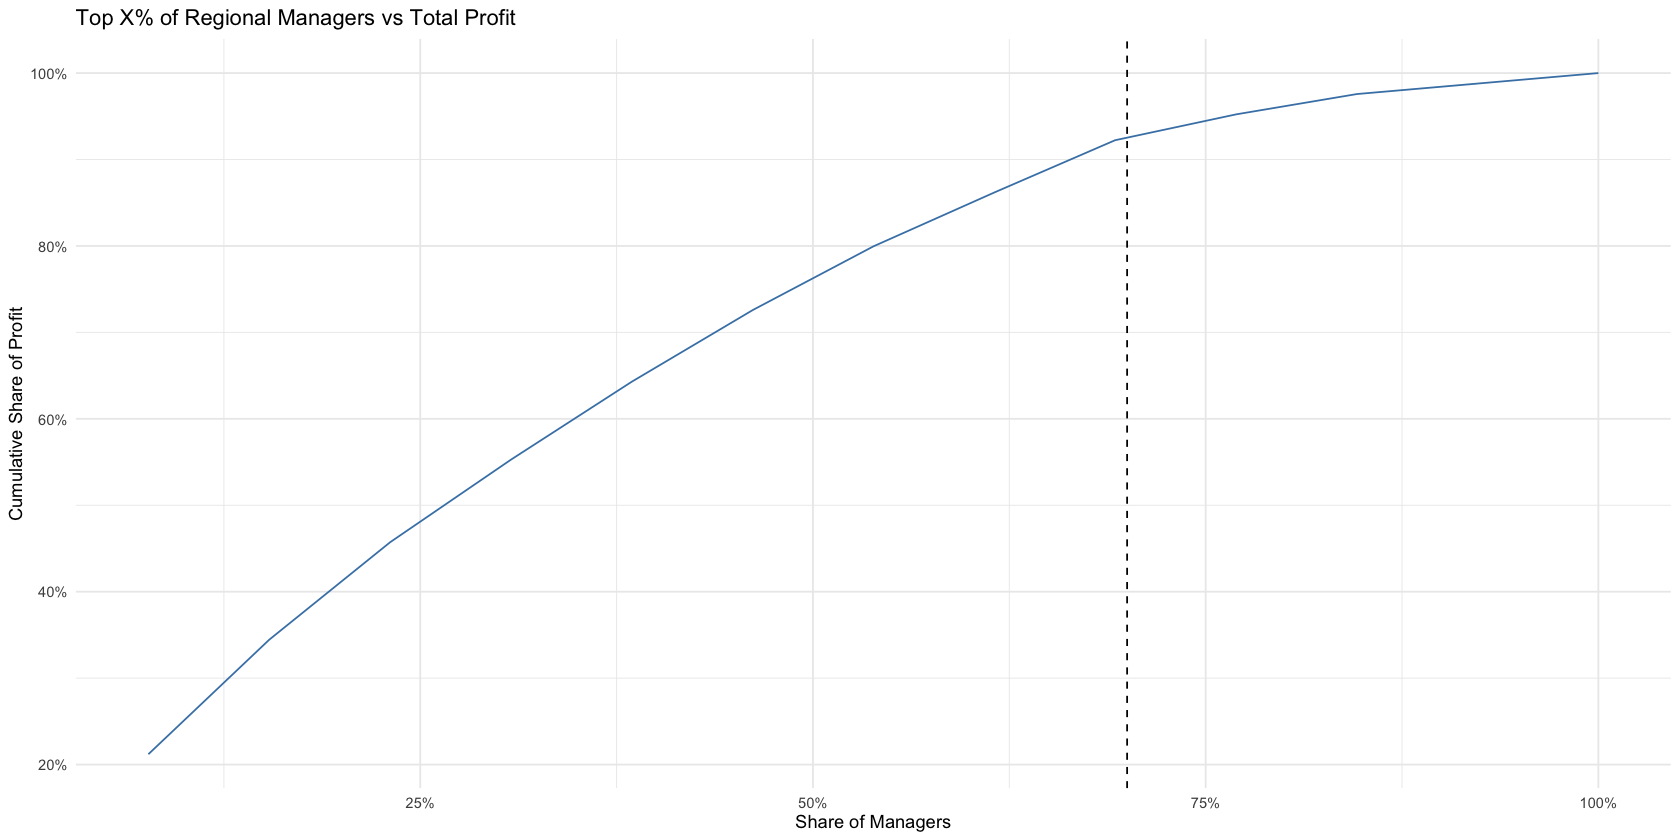

In [25]:
X <- 0.7

manager_profit <- orders_org |> 
    group_by(person) |> 
    summarise(profit = sum(profit)) |> 
    arrange(desc(profit)) |> 
    mutate(
        cum_profit = cumsum(profit),
        total_profit = sum(profit),
        cum_share = cum_profit / total_profit,
        manager_pct = row_number() / n()
    )

manager_profit |> 
    ggplot(aes(manager_pct, cum_share)) + 
    geom_line(color = "steelblue") + 
    geom_vline(xintercept = X, linetype = "dashed") + 
    scale_x_continuous(labels = scales::percent) + 
    scale_y_continuous(labels = scales::percent) + 
    labs(
        title = "Top X% of Regional Managers vs Total Profit",
        x = "Share of Managers",
        y = "Cumulative Share of Profit"
    ) + 
    theme_minimal()